# **DDoS attacks data analysis based on RDF-SVM**
AUTHOR: Yasaswi Kolasani


Import Dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

train = pd.read_csv('/content/drive/My Drive/DDoS/data/KDDTrain+.txt')
test = pd.read_csv('/content/drive/My Drive/DDoS/data/KDDTest+.txt')

In [ ]:
test.columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","lnum_compromised","lroot_shell","lsu_attempted","lnum_root","lnum_file_creations","lnum_shells","lnum_access_files","lnum_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","level"]

In [ ]:
train.columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","lnum_compromised","lroot_shell","lsu_attempted","lnum_root","lnum_file_creations","lnum_shells","lnum_access_files","lnum_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","level"]

# **Validate Data**

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  lnum_compromised             125972 non-null  int64  
 13 

In [ ]:
for i in train.columns:
  print("-------------------------")
  print(train[i].value_counts())


-------------------------
duration
0        115954
1          1989
2           843
3           557
4           351
          ...  
4946          1
5284          1
20771         1
3294          1
679           1
Name: count, Length: 2981, dtype: int64
-------------------------
protocol_type
tcp     102688
udp      14993
icmp      8291
Name: count, dtype: int64
-------------------------
service
http         40338
private      21853
domain_u      9043
smtp          7313
ftp_data      6859
             ...  
tftp_u           3
http_8001        2
aol              2
harvest          2
http_2784        1
Name: count, Length: 70, dtype: int64
-------------------------
flag
SF        74944
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
OTH          46
Name: count, dtype: int64
-------------------------
src_bytes
0        49392
8         3691
1         2432
44        2334
45        2089
         ... 

In [ ]:
for i in test.columns:
  print("-------------------------")
  print(test[i].value_counts())

-------------------------
duration
0       19017
1         587
4         539
282       240
280       216
        ...  
948         1
7280        1
8233        1
111         1
8209        1
Name: count, Length: 624, dtype: int64
-------------------------
protocol_type
tcp     18879
udp      2621
icmp     1043
Name: count, dtype: int64
-------------------------
service
http       7853
private    4773
telnet     1626
pop_3      1019
smtp        934
           ... 
printer      11
ntp_u        10
rje           8
tim_i         6
tftp_u        1
Name: count, Length: 64, dtype: int64
-------------------------
flag
SF        14875
REJ        3849
S0         2013
RSTO        773
RSTR        669
S3          249
SH           73
S1           21
S2           15
OTH           4
RSTOS0        2
Name: count, dtype: int64
-------------------------
src_bytes
0        7625
1         473
105       362
54540     325
44        313
         ... 
65264       1
93          1
5470        1
369         1
794    

# **Change categorical data to numerical**

In [ ]:
train["protocol_type"].value_counts() # because of minimal elements, we can proceed with onehotencoder

protocol_type
tcp     102688
udp      14993
icmp      8291
Name: count, dtype: int64

In [ ]:
train["lnum_outbound_cmds"].value_counts()

lnum_outbound_cmds
0    125972
Name: count, dtype: int64

In [ ]:
test["lnum_outbound_cmds"].value_counts()

lnum_outbound_cmds
0    22543
Name: count, dtype: int64

In [ ]:
# we can remove the column lnum_outbound_cmds because this contains only zeros.
train.drop("lnum_outbound_cmds", axis = 1, inplace=True)
test.drop("lnum_outbound_cmds", axis = 1, inplace=True)

y_train = train["label"]
y_test = test["label"]

y_train[y_train != "normal"] = "anomaly"
y_test[y_test != "normal"] = "anomaly"

train.drop("level", axis = 1, inplace=True)
test.drop("level", axis = 1, inplace=True)
train.drop("label", axis = 1, inplace=True)
test.drop("label", axis = 1, inplace=True)

protocol_train_data = pd.get_dummies(train["protocol_type"],drop_first = True)
train.drop("protocol_type", axis = 1, inplace=True)
train = pd.concat([train, protocol_train_data], axis=1)

protocol_test_data = pd.get_dummies(test["protocol_type"],drop_first = True)
test.drop("protocol_type", axis = 1, inplace=True)
test = pd.concat([test, protocol_test_data], axis=1)

In [ ]:
le= preprocessing.LabelEncoder()
train['service']=le.fit_transform(train['service']) # we have 66 unique values in service column, so we choose label encoder, instead of onehot encoding
train['flag']=le.fit_transform(train['flag']) # we have 11 unique values in flag column, so we choose label encoder, instead of onehot encoding

test['service']=le.fit_transform(test['service'])
test['flag']=le.fit_transform(test['flag'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   service                      125972 non-null  int64  
 2   flag                         125972 non-null  int64  
 3   src_bytes                    125972 non-null  int64  
 4   dst_bytes                    125972 non-null  int64  
 5   land                         125972 non-null  int64  
 6   wrong_fragment               125972 non-null  int64  
 7   urgent                       125972 non-null  int64  
 8   hot                          125972 non-null  int64  
 9   num_failed_logins            125972 non-null  int64  
 10  logged_in                    125972 non-null  int64  
 11  lnum_compromised             125972 non-null  int64  
 12  lroot_shell                  125972 non-null  int64  
 13 

<Axes: >

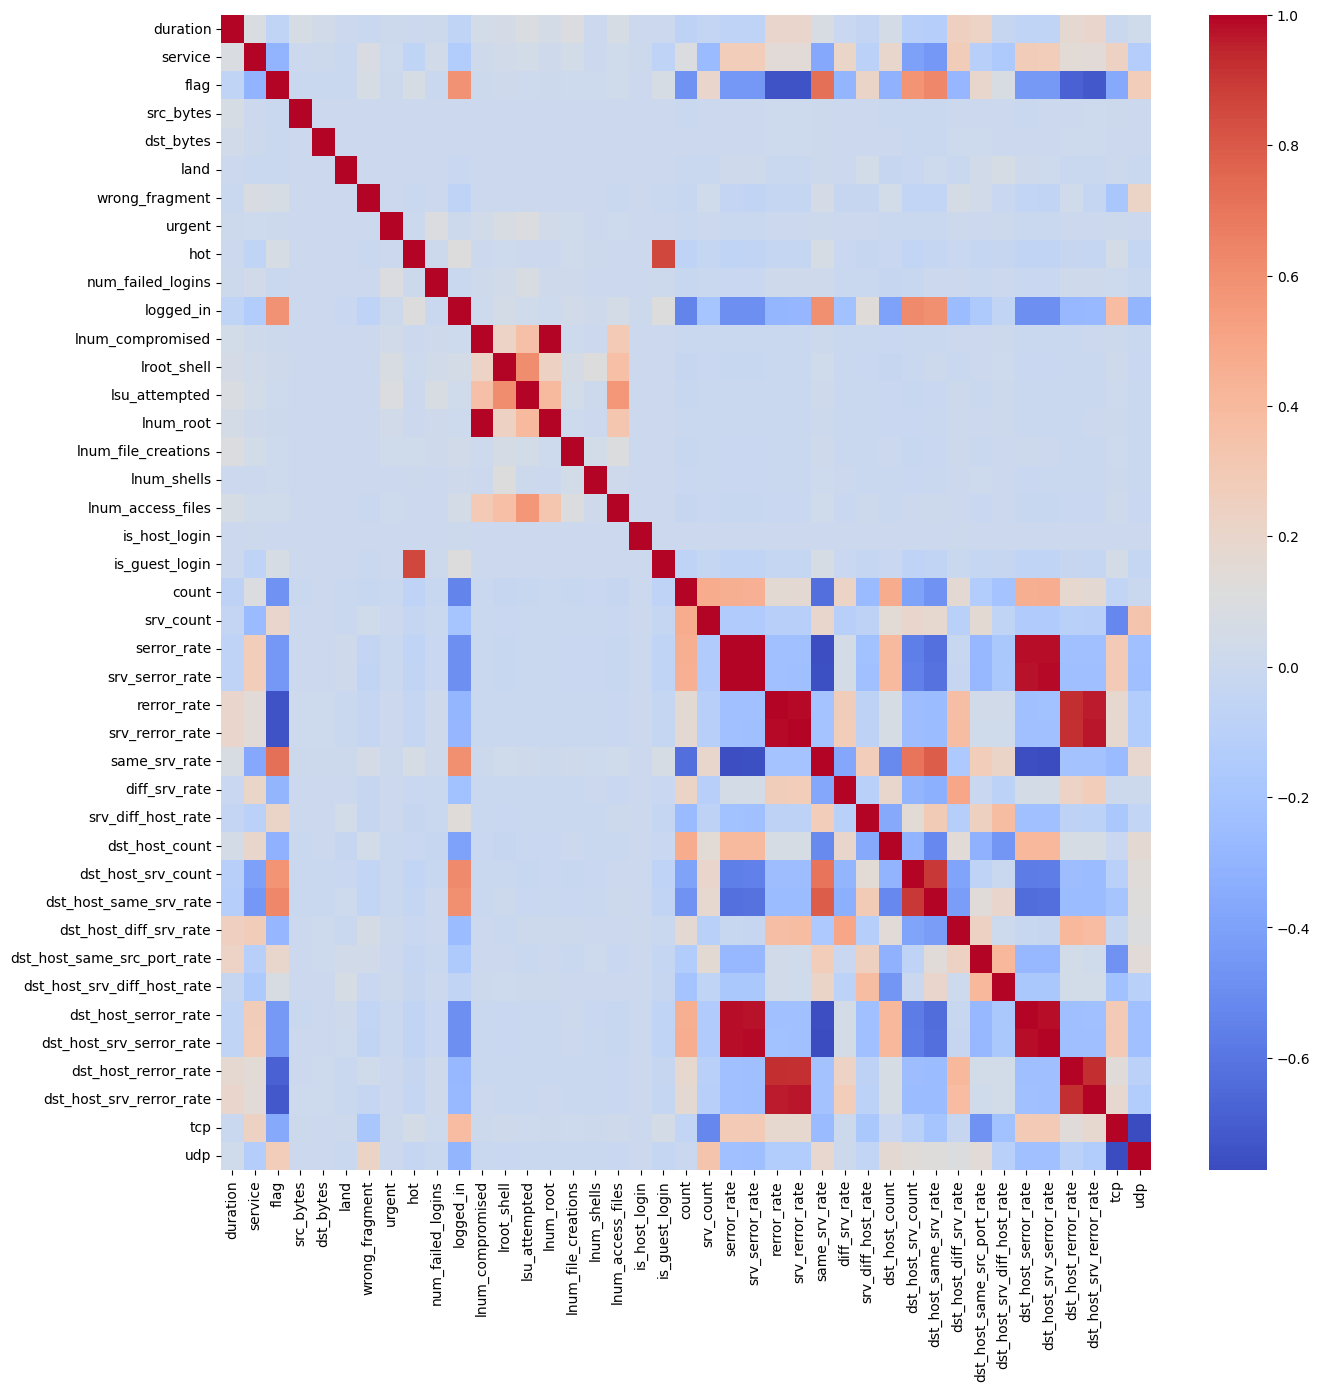

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(train.corr(), cmap='coolwarm')

<Axes: >

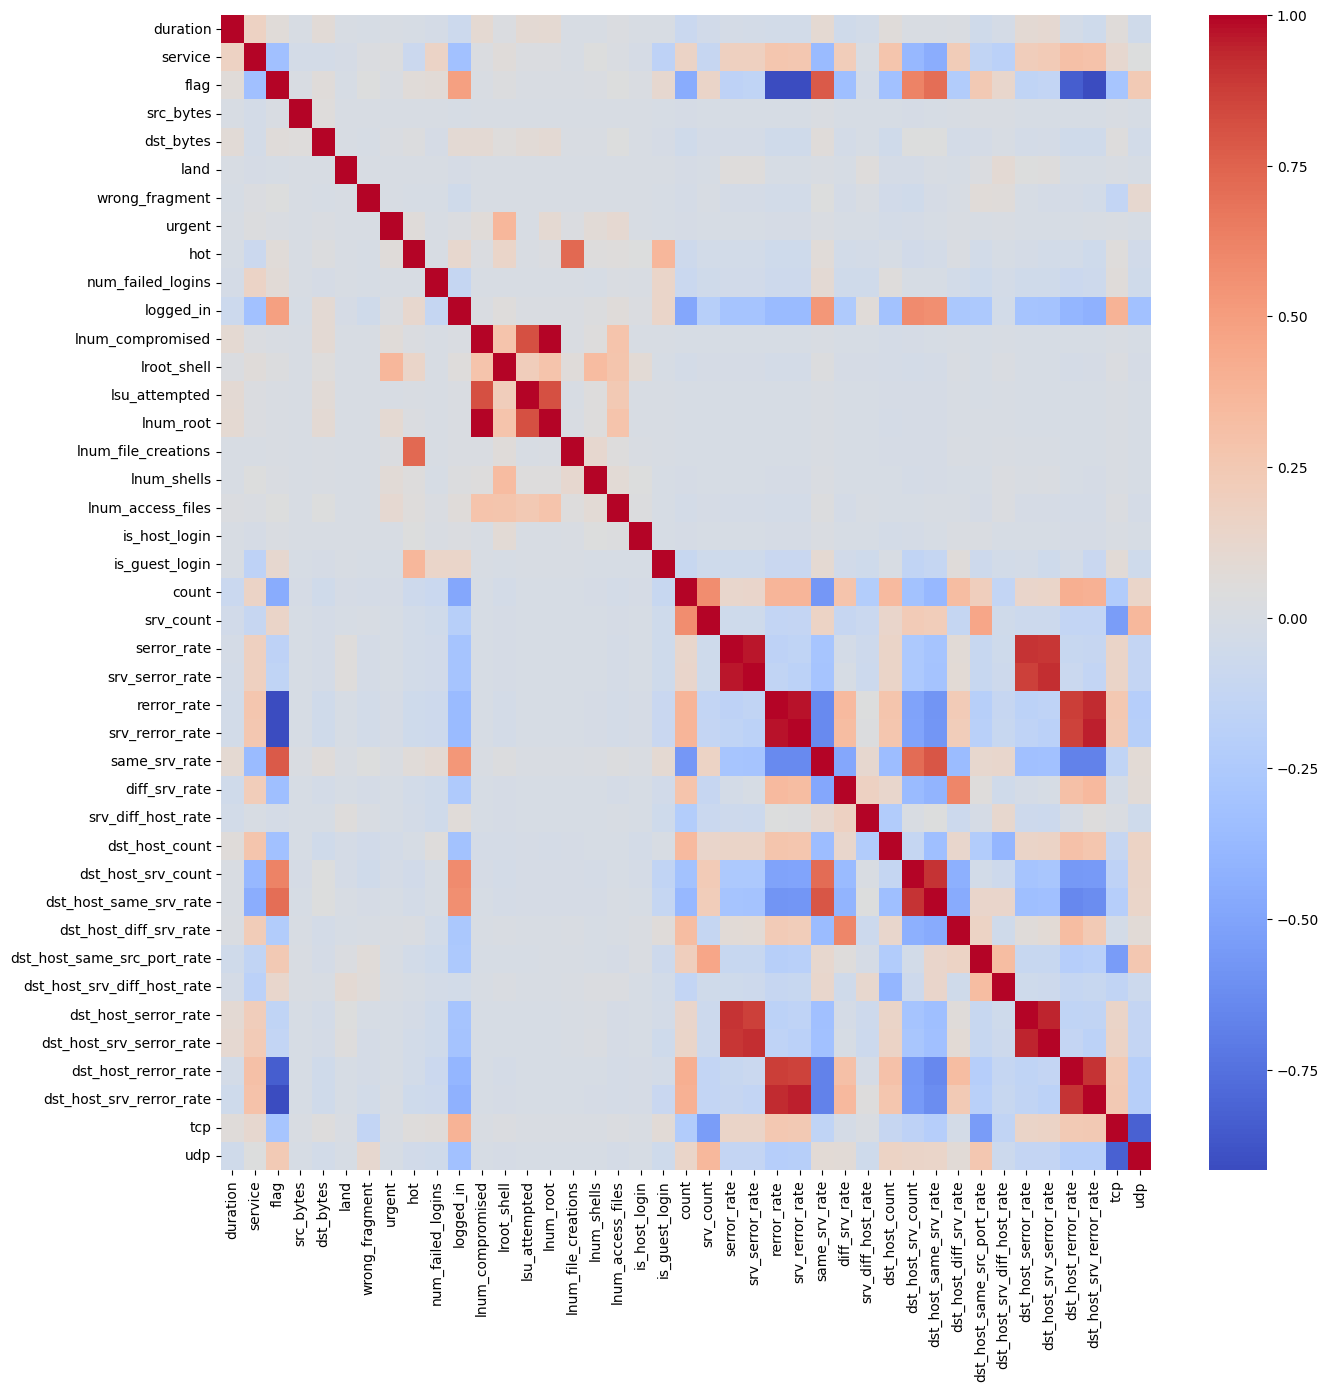

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(test.corr(), cmap='coolwarm')

# **Remove columns with high correlation**

In [ ]:
corr_matrix = train.corr().abs()

In [ ]:
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)
)

In [ ]:
high_corr = [column for column in upper.columns if any(upper[column] > 0.85)]
high_corr

['lnum_root',
 'is_guest_login',
 'srv_serror_rate',
 'srv_rerror_rate',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [ ]:
train.drop(high_corr, axis =1, inplace= True)
test.drop(high_corr, axis =1, inplace= True)

<Axes: >

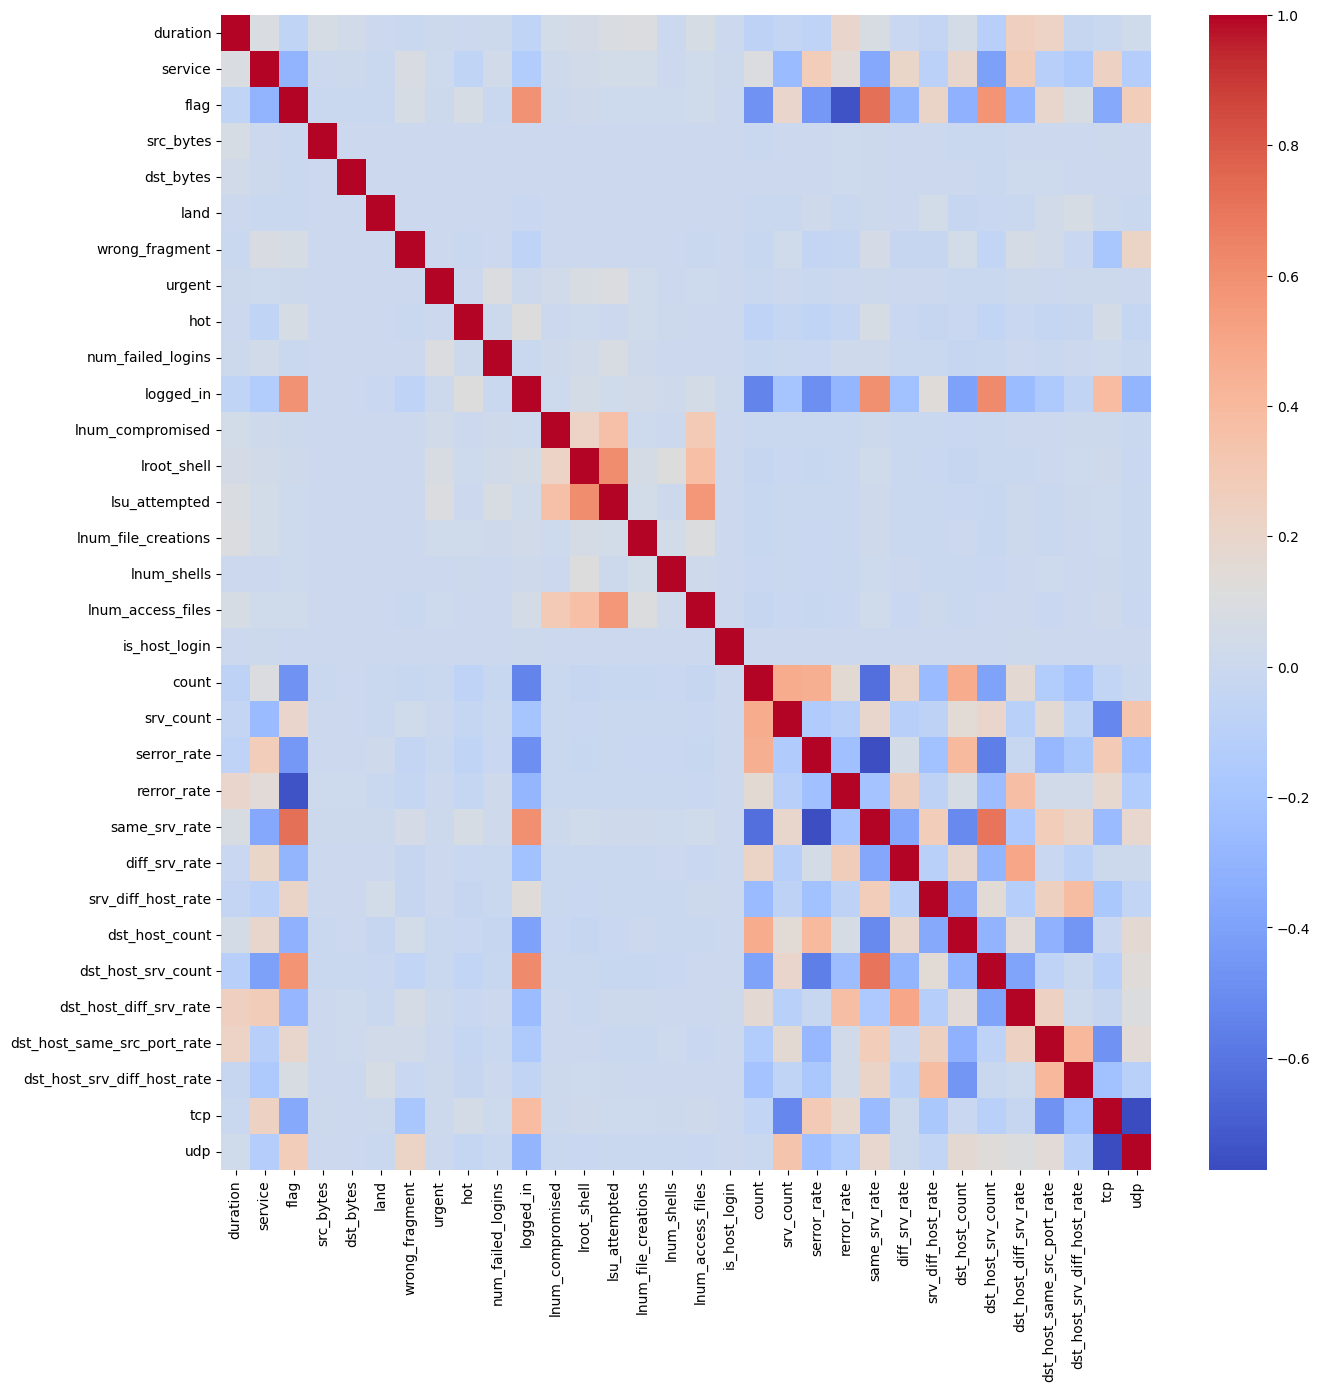

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(train.corr(), cmap='coolwarm')

In [ ]:
cols = train.columns

In [ ]:
train.describe()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate
count,125972.000000,125972.000000,125972.00000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,...,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,31.226558,6.97998,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,...,0.284487,0.119959,0.660925,0.063053,0.097322,182.149200,115.653725,0.082952,0.148379,0.032543
std,2604.525522,16.346504,2.68937,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,...,0.446457,0.320437,0.439624,0.180315,0.259831,99.206565,110.702886,0.188922,0.308998,0.112564
min,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,5.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.000000,0.000000,0.000000
50%,0.000000,24.000000,9.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.020000,0.000000,0.000000
75%,0.000000,49.000000,9.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,0.070000,0.060000,0.020000
max,42908.000000,69.000000,10.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000


In [ ]:
# standardize the data for SVM, because it cant handle wide range of data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train[['duration', 'service', 'src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count','count','srv_count','dst_host_count','dst_host_srv_count']])
scaled_test_data = scaler.fit_transform(test[['duration', 'service', 'src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count','count','srv_count','dst_host_count','dst_host_srv_count']])

In [ ]:
train[['duration', 'service', 'src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count','count','srv_count','dst_host_count','dst_host_srv_count']] = scaled_train_data
test[['duration', 'service', 'src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count','count','srv_count','dst_host_count','dst_host_srv_count']] = scaled_test_data

In [ ]:
train

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,tcp,udp
0,-0.110250,0.781420,9,-0.007737,-0.004919,0,0,0,0,0,...,0.08,0.15,0.00,0.734337,-1.035693,0.60,0.88,0.00,False,True
1,-0.110250,1.087297,5,-0.007762,-0.004919,0,0,0,0,0,...,0.05,0.07,0.00,0.734337,-0.809862,0.05,0.00,0.00,True,False
2,-0.110250,-0.442088,9,-0.007723,-0.002891,0,0,0,0,0,...,1.00,0.00,0.00,-1.533667,1.258746,0.00,0.03,0.04,True,False
3,-0.110250,-0.442088,9,-0.007728,-0.004814,0,0,0,0,0,...,1.00,0.00,0.09,0.734337,1.258746,0.00,0.00,0.00,True,False
4,-0.110250,1.087297,1,-0.007762,-0.004919,0,0,0,0,0,...,0.16,0.06,0.00,0.734337,-0.873095,0.07,0.00,0.00,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,-0.110250,1.087297,5,-0.007762,-0.004919,0,0,0,0,0,...,0.14,0.06,0.00,0.734337,-0.818895,0.06,0.00,0.00,True,False
125968,-0.107178,1.087297,9,-0.007744,-0.004883,0,0,0,0,0,...,1.00,0.00,0.00,0.734337,1.159381,0.01,0.01,0.00,False,True
125969,-0.110250,1.393174,9,-0.007382,-0.004823,0,0,0,0,0,...,1.00,0.00,0.00,0.734337,-0.773729,0.06,0.00,0.00,True,False
125970,-0.110250,-0.075035,5,-0.007762,-0.004919,0,0,0,0,0,...,0.06,0.05,0.00,0.734337,-0.972460,0.05,0.00,0.00,True,False


In [ ]:
x_train = train
x_test = test

In [ ]:
# Using grid search for getting best value for n_estimators hyper parameter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Specify the values to try
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
}
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_n_estimators = grid_search.best_params_
best_n_estimators

{'max_depth': None, 'n_estimators': 100}

Implement Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = 20, n_estimators = 100)
clf.fit(x_train,y_train)
pred=clf.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     anomaly       0.87      0.76      0.81     12832
      normal       0.73      0.86      0.79      9711

    accuracy                           0.80     22543
   macro avg       0.80      0.81      0.80     22543
weighted avg       0.81      0.80      0.80     22543



In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, pred, labels=y_test.unique())
pd.DataFrame(conf_matrix)

,0,1
0,9750,3082
1,1397,8314


Sort the features based on feature importances

In [ ]:
feat_array=sorted(np.c_[range(len(x_train.columns)),x_train.columns,clf.feature_importances_],reverse=True,key=lambda x:x[2])
for i in feat_array:
  print(i)

[3 'src_bytes' 0.18897651701717064]
[4 'dst_bytes' 0.11878583550650955]
[26 'dst_host_srv_count' 0.10172459395190898]
[2 'flag' 0.08241889907413161]
[10 'logged_in' 0.0676463554051772]
[22 'same_srv_rate' 0.06562637093753503]
[23 'diff_srv_rate' 0.06252183159218318]
[27 'dst_host_diff_srv_rate' 0.0542854823464271]
[18 'count' 0.04006926575894749]
[1 'service' 0.036340428978075434]
[29 'dst_host_srv_diff_host_rate' 0.03232563600971455]
[28 'dst_host_same_src_port_rate' 0.030603455563752456]
[20 'serror_rate' 0.02755901063982041]
[19 'srv_count' 0.020268029479439092]
[25 'dst_host_count' 0.018482755435609913]
[30 'tcp' 0.012936596645169727]
[8 'hot' 0.010464390767176838]
[11 'lnum_compromised' 0.0075072755149743165]
[31 'udp' 0.005758128621496299]
[0 'duration' 0.004682645802011317]
[21 'rerror_rate' 0.004246696968791182]
[6 'wrong_fragment' 0.003598189507419579]
[24 'srv_diff_host_rate' 0.0023968086204154597]
[14 'lnum_file_creations' 0.00022565941732471592]
[9 'num_failed_logins' 0.000

Get the top features with highest importance

In [ ]:
alpha=0.01
A_index=[]
B_index=[]
max_feature=0.0
for feature in feat_array:
    if feature[2]>alpha:
        A_index.append(feature[0])
        if max_feature<feature[2]:
               max_feature=feature[2]
    else:
        B_index.append(feature[0])

In [ ]:
A_index # selected features

[3, 4, 26, 2, 10, 22, 23, 27, 18, 1, 29, 28, 20, 19, 25, 30, 8]

Implement SVM by adding each neglected feature

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import precision_score,accuracy_score,recall_score
sum1=0.00
k=0
for xi in B_index:
        k+=1
        clfA = SVC(kernel='linear',C=1.0,gamma=0.2,cache_size=7000)
        clfB = SVC(kernel='linear',C=1.0,gamma=0.2,cache_size=7000)
        print("SVC initialization done");
        clfA.fit(x_train.iloc[:,A_index],y_train)
        print(str(k)," SVM on A is done........")
        clfB.fit(x_train.iloc[:,A_index+[xi]],y_train)
        print(str(k)," SVM on B is done........")
        predictA=clfA.predict(x_test.iloc[:,A_index])
        predictB=clfB.predict(x_test.iloc[:,A_index+[xi]])
        first=precision_score(y_test,predictA,average="micro")
        second=precision_score(y_test,predictB,average="micro")
        resu=second-first
        print(resu)
        if(resu>0.000000001):
          A_index.append(xi)

SVC initialization done
1  SVM on A is done........
1  SVM on B is done........
-0.002262343077673812
SVC initialization done
2  SVM on A is done........
2  SVM on B is done........
0.004258528146209417
SVC initialization done
3  SVM on A is done........
3  SVM on B is done........
0.002572860755001627
SVC initialization done
4  SVM on A is done........
4  SVM on B is done........
0.002040544736725325
SVC initialization done
5  SVM on A is done........
5  SVM on B is done........
-0.014993567848112455
SVC initialization done
6  SVM on A is done........
6  SVM on B is done........
0.0002661580091380955
SVC initialization done
7  SVM on A is done........
7  SVM on B is done........
-0.00022179834094837592
SVC initialization done
8  SVM on A is done........
8  SVM on B is done........
0.0
SVC initialization done
9  SVM on A is done........
9  SVM on B is done........
0.0
SVC initialization done
10  SVM on A is done........
10  SVM on B is done........
-4.435966818971959e-05
SVC initializa

In [ ]:
A_index

[3,
 4,
 2,
 18,
 22,
 26,
 23,
 20,
 27,
 28,
 10,
 1,
 29,
 25,
 19,
 30,
 31,
 8,
 21,
 0,
 24,
 9]

In [ ]:
len(A_index)

22

In [ ]:
A_index = [3,
 4,
 2,
 18,
 22,
 26,
 23,
 20,
 27,
 28,
 10,
 1,
 29,
 25,
 19,
 30,
 31,
 8,
 21,
 0,
 24,
 9]
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import precision_score,accuracy_score,recall_score

In [ ]:
clfran = SVC(kernel='linear')
clfran.fit(x_train.iloc[:,A_index],y_train)
predran=clfran.predict(x_test.iloc[:,A_index])

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predran, labels=y_test.unique())
pd.DataFrame(conf_matrix)

,0,1
0,7827,5005
1,362,9349


Implement cross validation to to overcome overfitting of data

In [ ]:
from sklearn.model_selection import cross_val_score
acc1=cross_val_score(clfran,x_test.iloc[:,A_index],y_test,scoring='accuracy',cv=10)
acc1=np.mean(acc1)
acc1

0.9364322210133451

In [ ]:
prec1 =precision_score(y_test,predran,average='micro')
prec1=cross_val_score(clfran,x_test.iloc[:,A_index],y_test,scoring='precision_weighted',cv=50)
prec1=np.mean(prec1)
print("precision: ",prec1) #Precision of RF-SVM
reca1 = recall_score(y_test,predran,average='micro')
reca1=cross_val_score(clfran,x_test.iloc[:,A_index],y_test,scoring='recall_weighted',cv=50)
reca1=np.mean(reca1) #Recall of RF-SVM
print("Recall: ",reca1)

precision:  0.9383147656685368
Recall:  0.9365203252032521


In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=100)
precision_scores = []
recall_scores = []

temp_train = pd.concat([x_train, x_test], axis=0)
temp_test = pd.concat([y_train, y_test], axis = 0)
for train_index, test_index in skf.split(temp_train.iloc[:, A_index], temp_test):
    X_train, X_test = temp_train.iloc[train_index, A_index], temp_train.iloc[test_index, A_index]
    Y_train, y_test_fold = temp_test.iloc[train_index], temp_test.iloc[test_index]
    clfran.fit(X_train, Y_train)
    predran = clfran.predict(X_test)
    prec_fold = precision_score(y_test_fold, predran, average='weighted')
    rec_fold = recall_score(y_test_fold, predran, average='weighted')
    precision_scores.append(prec_fold)
    recall_scores.append(rec_fold)

prec1 = np.mean(precision_scores)
reca1 = np.mean(recall_scores)

In [45]:
prec1

0.9314838055245463

In [46]:
reca1

0.9295761245390981

In [47]:
A_index

[3,
 4,
 2,
 18,
 22,
 26,
 23,
 20,
 27,
 28,
 10,
 1,
 29,
 25,
 19,
 30,
 31,
 8,
 21,
 0,
 24,
 9]